In [1]:
!pip install mlflow boto3 awscli optuna plotly catboost


In [ ]:
!aws configure set aws_access_key_id #hided for security
!aws configure set aws_secret_access_key #hided for security
!aws configure set default.region us-east-1

In [3]:
import mlflow
# Step 2: Set up the MLflow tracking server
mlflow.set_tracking_uri("http://ec2-3-87-202-243.compute-1.amazonaws.com:5000")

In [4]:
# Set or create an experiment
mlflow.set_experiment("Stacking HP Tuning")

2026/02/28 17:33:12 INFO mlflow.tracking.fluent: Experiment with name 'Stacking HP Tuning' does not exist. Creating a new experiment.


<Experiment: artifact_location='s3://mlflow-tracking-bucket26/12', creation_time=1772280193571, experiment_id='12', last_update_time=1772280193571, lifecycle_stage='active', name='Stacking HP Tuning', tags={}>

In [5]:
import pandas as pd

df = pd.read_csv('youtube_preprocessing.csv').dropna()
df.shape

(3118, 3)

In [10]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
import mlflow
import mlflow.sklearn
import optuna
import matplotlib.pyplot as plt

c:\Users\Urmi Kanrar\anaconda3\envs\sentiment\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
# Step 1: Remap the class labels from [-1, 0, 1] to [2, 0, 1]
df['sentiment_encoded'] = df['sentiment_encoded'].map({-1: 2, 0: 0, 1: 1})

# Step 2: Remove rows where the target labels (category) are NaN
df = df.dropna(subset=['sentiment_encoded'])

In [12]:
# Step 3: TF-IDF vectorizer setup
ngram_range = (1, 3)  # Trigram
max_features = 1000  # Set max_features to 1000
vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features)
X = vectorizer.fit_transform(df['Comment'])
y = df['sentiment_encoded']

# Step 4: Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

c:\Users\Urmi Kanrar\anaconda3\envs\sentiment\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Urmi Kanrar\anaconda3\envs\sentiment\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Urmi Kanrar\anaconda3\envs\sentiment\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Urmi Kanrar\anaconda3\envs\sentiment\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Urmi Kanrar\anaconda3

In [13]:
# Step 5: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

In [6]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier

In [ ]:
#from mlflow extracting hyperparameters from best trials
from mlflow.tracking import MlflowClient

client = MlflowClient()

# Run IDs
gb_run_id = "aa4e68c42fea4119a231dd442faafa10"
cat_run_id = "794644e40ec8403db2f24775335a0721"
lr_run_id = "5c2c432621dc45c98c90c1712702c9ad"
nb_run_id = "65575e15debd433590384a6f0bc23951"

# Fetch runs
gb_run = client.get_run(gb_run_id)
cat_run = client.get_run(cat_run_id)
lr_run = client.get_run(lr_run_id)
nb_run = client.get_run(nb_run_id)

# Extract params
gb_params = gb_run.data.params
cat_params = cat_run.data.params
lr_params = lr_run.data.params
nb_params = nb_run.data.params

print("GradientBoosting params:", gb_params)
print("CatBoost params:", cat_params)
print("Logistic params:", lr_params)
print("NaiveBayes params:", nb_params)

GradientBoosting params: {'algo_name': 'GradientBoosting', 'n_estimators': '468', 'learning_rate': '0.13066502758540927', 'max_depth': '3'}
CatBoost params: {'algo_name': 'CatBoost', 'depth': '8', 'learning_rate': '0.27035817720878363', 'iterations': '587'}
Logistic params: {'algo_name': 'LogisticRegression', 'C': '2.9007777401612693'}
NaiveBayes params: {'algo_name': 'NaiveBayes', 'alpha': '0.0030594497271337812'}


In [8]:


# Convert params properly

# Gradient Boosting
gb_model = GradientBoostingClassifier(
    n_estimators=int(gb_params["n_estimators"]),
    learning_rate=float(gb_params["learning_rate"]),
    max_depth=int(gb_params["max_depth"]),
    random_state=42
)

# CatBoost
cat_model = CatBoostClassifier(
    depth=int(cat_params["depth"]),
    learning_rate=float(cat_params["learning_rate"]),
    iterations=int(cat_params["iterations"]),
    verbose=0,
    random_state=42
)

# Logistic Regression (Softmax)
lr_model = LogisticRegression(
    C=float(lr_params["C"]),
    max_iter=2000,
    multi_class="multinomial",
    solver="lbfgs"
)

# Naive Bayes
nb_model = MultinomialNB(
    alpha=float(nb_params["alpha"])
)

In [9]:


base_models = [
    ("nb", nb_model),
    ("lr", lr_model),
    ("gb", gb_model),
    ("cat", cat_model)
]

meta_model = LogisticRegression(max_iter=2000)

stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    stack_method="predict_proba",
    n_jobs=-1
)

Accuracy: 0.7766069546891464
Macro F1: 0.7744968112586216
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       316
           1       0.78      0.72      0.75       316
           2       0.76      0.71      0.73       317

    accuracy                           0.78       949
   macro avg       0.78      0.78      0.77       949
weighted avg       0.78      0.78      0.77       949

Confusion Matrix:
[[283  13  20]
 [ 36 228  52]
 [ 39  52 226]]


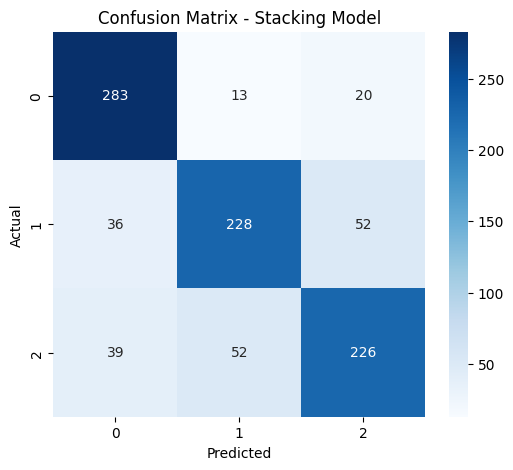

2026/02/28 17:51:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/02/28 17:52:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run Stacking_BestModels at: http://ec2-3-87-202-243.compute-1.amazonaws.com:5000/#/experiments/12/runs/8b5cc5cbea8642bdbe842e2b142d3025.
2026/02/28 17:52:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://ec2-3-87-202-243.compute-1.amazonaws.com:5000/#/experiments/12.


In [14]:
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow.sklearn
import numpy as np

with mlflow.start_run(run_name="Stacking_BestModels"):

    # Train
    stacking_model.fit(X_train, y_train)

    # Predict
    y_pred = stacking_model.predict(X_test)

    # ------------------ Metrics ------------------
    accuracy = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average="macro")

    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("macro_f1", macro_f1)

    print("Accuracy:", accuracy)
    print("Macro F1:", macro_f1)

    # Classification Report
    classification_rep = classification_report(y_test, y_pred, output_dict=True)
    print(classification_report(y_test, y_pred))

    for label, metrics in classification_rep.items():
        if isinstance(metrics, dict):
            for metric, value in metrics.items():
                mlflow.log_metric(f"{label}_{metric}", value)

    # ------------------ Confusion Matrix ------------------
    cm = confusion_matrix(y_test, y_pred)

    print("Confusion Matrix:")
    print(cm)

    # Plot confusion matrix
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["0","1","2"],
                yticklabels=["0","1","2"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix - Stacking Model")

    # Save figure
    plt.savefig("stacking_confusion_matrix.png")
    mlflow.log_artifact("stacking_confusion_matrix.png")

    plt.show()

    # Log model
    mlflow.sklearn.log_model(stacking_model, "Stacking_model")

    mlflow.log_param("base_models",
                     "GradientBoosting + CatBoost + Softmax + NaiveBayes")